In [207]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

from scipy.interpolate import interp2d
from scipy.stats import beta, multivariate_normal

**Inputs**:
- A small number of calibration data for each class $k$
- A prior distribution on the Beta distribution parameters. Eventually, we will want to estimate these using maximum likelihood (a la empirical Bayes), but until I figure out how to do that, we will use the KDE distribution fit to the "ground truth" parameters (estimated using all of ImageNet train)

## 1. Prepare inputs

In [2]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [51]:
# Select subset of data

n = 20 # Number of calibration points per class k
num_classes = 1000

softmax_scores_subset = np.zeros((num_classes * n, num_classes))
labels_subset = np.zeros((num_classes * n, ), dtype=np.int8)

for k in range(num_classes):
    
    # Randomly select n instances of class k
    idx = np.argwhere(labels==k).flatten()
    selected_idx = np.random.choice(idx, replace=False, size=(n,))
    
    softmax_scores_subset[n*k:n*(k+1), :] = softmax_scores[selected_idx, :]
    labels_subset[n*k:(n+1)*k] = k

In [58]:
# Only select data for which k is true class
scores_subset = [softmax_scores_subset[row,labels_subset[row]] for row in range(len(labels_subset))]

In [16]:
# Load KDE estimate of prior
with open('.cache/kde.pkl', 'rb') as f:
    kde = pickle.load(f)

## 2. Estimate quantiles

Let $f(x; \alpha, \beta) := \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$ denote the probability density function of $Beta(\alpha, \beta)$. Let $D(\alpha, \beta)$ denote the prior distribution of the Beta distribution parameters $\alpha$ and $\beta$. 

The distribution of an arbitrary score $s_{k,new}$ for class $k$ is a mixture of Betas:
$$p(s_{k,new}) = \int_0^{\infty} \int_0^{\infty} f(s_{k,new}; \alpha_k, \beta_k) p(\alpha_k, \beta_k | s_k, D) d\alpha_k d\beta_k$$


First, let's figure out how to sample from $p(\alpha_k, \beta_k | s_k, D)$

**Step 1**: Plot $p(\alpha_k, \beta_k | s_k, D)\propto \prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k) D(\alpha, \beta)$

In [203]:
xmin, xmax = 0,4 # Grid bounds
ymin, ymax = 0,4 # Grid bounds
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
positions = np.vstack([X.ravel(), Y.ravel()])

In [97]:
D = kde(positions)

In [98]:
def compute_classk_prod_f(k, a, b, logscale=False):
    '''
    Inputs:
        k: class
        a, b: parameters of Beta(a,b)
    '''
    f_ski = beta.pdf(scores_subset[k*n:(k+1)*n], a, b)
    
    if logscale:
        log_prod = np.sum(np.log(f_ski))
        return log_prod
    else:     
        prod = np.prod(f_ski)
        return prod
    

Let's first check if this works for a single class (class 0)

In [191]:
k = 2

In [192]:
# Use normal scale
prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i]) for i in range(len(positions[0]))])
prob = prod_f * D
max_prob = np.nanmax(prod_f * D)
max_prob

3.604109941878099e+56

In [240]:
# Replace nan entries with 0
prob[np.isnan(prob)] = 0

In [193]:
# # Use log scale
# log_prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i], logscale=True) for i in range(len(positions[0]))])

In [194]:
# log_prob = log_prod_f + np.log(D)
# max_log_prob = np.nanmax(log_prob)
# np.exp(max_log_prob)

Nice! The normal and log scale computations match.

Let's also plot the density to get a sense of where most of the probability mass lies

In [241]:
# Reshape probs from vector into square matrix
log_density = np.reshape(log_prob, X.shape) 
density = np.reshape(prob, X.shape) 

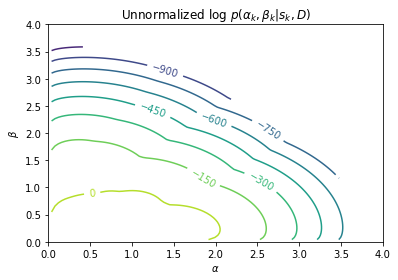

In [242]:
CS = plt.contour(X,Y,log_density)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Unnormalized log $p(\\alpha_k, \\beta_k | s_k, D)$')
plt.show()

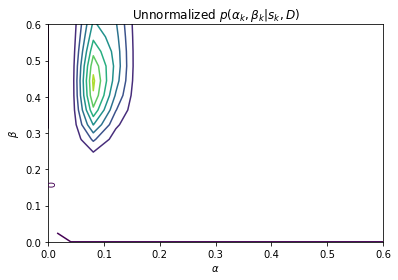

In [289]:
CS = plt.contour(X,Y,density)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Unnormalized $p(\\alpha_k, \\beta_k | s_k, D)$')
plt.ylim(0, 0.6)
plt.xlim(0, 0.6)
plt.show()

Now, to do the rejection sampling, we can pick a 2D Gaussian centered at the $(\alpha, \beta)$ coordinate with the highest probability mass and then rescale it so that it coveres the unnormalized target distribution. We then sample from this 2D Gaussian and then accept the point with probability (density of unnormalized target distribution) / (rescaled Gaussian density)

Question: If I just rescale the density so that the peak covers the peak of the unnormalized target distribution, is that sufficient? I'm not sure if the tails of the Gaussian distribution are wide enough to cover the tails of the target distribution. Oh wait, but we can adjust the thickness of the tails by changing the covariance

In [380]:
# Get alpha, beta pair with highest probability
max_idx = np.argwhere(prob == max_prob)[0,0]
max_alpha = positions[0, max_idx]
max_beta = positions[1, max_idx]
print('max_alpha, max_beta:', max_alpha, max_beta)

max_alpha, max_beta: 0.08080808080808081 0.4444444444444445


In [395]:
# Plot log of rescaled normal density
variance = 0.01 # Diagonal of covariance matrix
k = max_prob / gaussian_rv.pdf([max_alpha, max_beta]) # Scaling factor

mean = [max_alpha, max_beta]
cov = [[variance, 0], [0, variance]]

gaussian_rv = multivariate_normal(mean, cov)
gaussian_density = gaussian_rv.pdf(positions.T)

rescaled_gaussian_density = k * gaussian_density
rescaled_gaussian_density = np.reshape(rescaled_gaussian_density, X.shape)

In [396]:
# Check if there are any grid points where rescaled sampling density does not cover target
print(np.sum(rescaled_gaussian_density < density)) # Want this to be 0

np.argwhere(rescaled_gaussian_density < density)

492


array([[ 1, 24],
       [ 1, 25],
       [ 1, 26],
       [ 1, 27],
       [ 1, 28],
       [ 1, 29],
       [ 1, 30],
       [ 1, 31],
       [ 1, 32],
       [ 1, 33],
       [ 1, 34],
       [ 1, 35],
       [ 1, 36],
       [ 1, 37],
       [ 1, 38],
       [ 1, 39],
       [ 1, 40],
       [ 1, 41],
       [ 1, 42],
       [ 1, 43],
       [ 1, 44],
       [ 1, 45],
       [ 1, 46],
       [ 1, 47],
       [ 1, 48],
       [ 1, 49],
       [ 1, 50],
       [ 1, 51],
       [ 1, 52],
       [ 1, 53],
       [ 1, 54],
       [ 1, 55],
       [ 1, 56],
       [ 1, 57],
       [ 1, 58],
       [ 1, 59],
       [ 1, 60],
       [ 1, 61],
       [ 1, 62],
       [ 1, 63],
       [ 1, 64],
       [ 2, 19],
       [ 2, 20],
       [ 2, 21],
       [ 2, 22],
       [ 2, 23],
       [ 2, 24],
       [ 2, 25],
       [ 2, 26],
       [ 2, 27],
       [ 2, 28],
       [ 2, 29],
       [ 2, 30],
       [ 2, 31],
       [ 2, 32],
       [ 2, 33],
       [ 2, 34],
       [ 2, 35],
       [ 2, 36

/tmp/ipykernel_8363/360660596.py:1: RuntimeWarning: divide by zero encountered in log
  CS = plt.contour(X,Y, np.log(rescaled_gaussian_density))


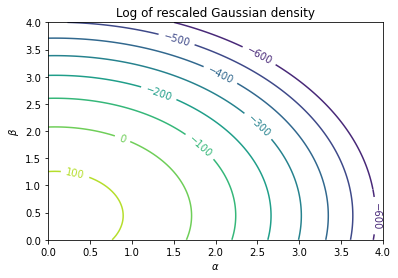

In [397]:
CS = plt.contour(X,Y, np.log(rescaled_gaussian_density))
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Log of rescaled Gaussian density')
plt.show()

In [201]:
# Density at mean
print("Density at mean:", k * gaussian_rv.pdf([max_alpha, max_beta]))

Density at mean: 3.9106326690342863e+56


Now that we've identified an appropriate sampling distribution, we can carry out the actual rejection sampling to get samples from $p(\alpha_k, \beta_k | s_k, D)$

In [376]:
def get_discretized_density(xnew, ynew, X, Y, disc_density):
    xmin, xmax = np.min(X), np.max(X)
    ymin, ymax = np.min(Y), np.max(Y)
    
    # For values within the bounds, return value at nearest (x,y)
    if xnew >= xmin and xnew <= xmax and ynew >= ymin and ynew <= ymax:
        sq_l2_dist = (X - xnew) ** 2 + (Y - ynew) ** 2
        closest_idx = np.argmin(sq_l2_dist)
        return disc_density[closest_idx]
    
    # For values outside bounds, return 0
    else:
        return 0
    
    
disc_target_density = lambda xnew, ynew : get_discretized_density(xnew, ynew, X, Y, prob)  

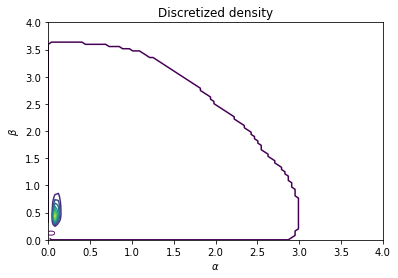

In [377]:
# Sanity check discretized density
disc_density_grid = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        disc_density_grid[i,j] = disc_target_density(X[i,j], Y[i,j])
    
CS = plt.contour(X, Y, disc_density_grid)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Discretized density')
plt.show()

In [378]:
def generate_n_samples(n, sampling_mean, sampling_cov, sampling_scaling, target_pdf):
    samples = []
    total_sampled = 0
    while len(samples) < n:
        sample = np.random.multivariate_normal(sampling_mean, sampling_cov) 
        accept_prob = target_pdf(sample[0], sample[1]) / (sampling_scaling * multivariate_normal(sampling_mean, sampling_cov).pdf(sample)) 
        unif_rv = np.random.rand()
        print()
        print('Accept prob', accept_prob)
#         print("unif", unif_rv)
        if unif_rv < accept_prob:
#             print('Accepted sample')
            samples.append(sample)
        else:
            pass
#             print('Rejected sample')
        total_sampled += 1
    
    print(f"***Accept rate***: {n/total_sampled * 100:.2f}%")
    return np.array(samples)
                
       
samples = generate_n_samples(5000, mean, cov, k, disc_target_density)


Accept prob 5.362337496696962e-11

Accept prob 0.007905607641790482

Accept prob 0.006257966785275136

Accept prob 0.006512613526021467

Accept prob 3.0202661948982314e-15

Accept prob 0.00022668165407511968

Accept prob 0.04120455051589137

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0010772409013225601

Accept prob 0.0

Accept prob 2.27742510543566e-05

Accept prob 1.2073890941397127

Accept prob 0.18190300489285582

Accept prob 0.07131757721571572

Accept prob 0.007281945757205455

Accept prob 1.0055475994315755

Accept prob 1.0284171942881468

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0003570924163905156

Accept prob 0.9846810059726856

Accept prob 0.5758074436129103

Accept prob 0.03179536923818714

Accept prob 1.5809574924540484

Accept prob 0.010154060851038541

Accept prob 0.9637745699058194

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.1153004539116451

Accept prob 0.4221713290279662

Accept prob 0.3764521214453504

Accept prob 0.0104783271817082


Accept prob 0.006558189762732775

Accept prob 0.0

Accept prob 1.119770970539328

Accept prob 0.986063080663381

Accept prob 8.275336684712252e-05

Accept prob 2.1880292249722686

Accept prob 0.0

Accept prob 0.0

Accept prob 0.009591645187043132

Accept prob 0.005544791601648506

Accept prob 6.358592031424137e-06

Accept prob 0.0

Accept prob 1.3811830458157035

Accept prob 0.0

Accept prob 0.4251900994122547

Accept prob 0.4957055670813718

Accept prob 0.004836911713954755

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.00026747132694882676

Accept prob 0.009573139792714035

Accept prob 0.013118280383696838

Accept prob 0.00010412200673390692

Accept prob 0.0

Accept prob 0.00033757612007314643

Accept prob 4.856910733640051e-06

Accept prob 0.0004748759456055614

Accept prob 0.0

Accept prob 0.052729997310968425

Accept prob 0.006596048053648079

Accept prob 0.009868946846323282

Accept prob 0.0

Accept prob 0.43329629266540803

Accept prob 0.0

A


Accept prob 0.01987777116392995

Accept prob 1.2160725054642447

Accept prob 0.0

Accept prob 5.2760962233601115e-06

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0111192082774936

Accept prob 0.007595858908541262

Accept prob 0.38299910701342166

Accept prob 0.0

Accept prob 1.0149020042319652

Accept prob 0.01095111866928327

Accept prob 0.0

Accept prob 0.6257860668853928

Accept prob 0.4268728704280727

Accept prob 0.3417130669552037

Accept prob 0.0

Accept prob 0.0

Accept prob 0.4855856301263881

Accept prob 0.4391800060867232

Accept prob 0.0

Accept prob 0.0

Accept prob 0.006855301106033549

Accept prob 0.0

Accept prob 0.48451254171030356

Accept prob 0.015139380012663088

Accept prob 3.457734053157872e-06

Accept prob 0.025210028950690595

Accept prob 0.000449876397150651

Accept prob 0.0

Accept prob 0.009001407316044983

Accept prob 0.0004253215634452737

Accept prob 0.0

Accept prob 0.05563898658198542

Accept prob 1.0008400407735853

Accept prob 1.1442435291751516




Accept prob 0.016398912224304604

Accept prob 0.0

Accept prob 0.022249386915468433

Accept prob 0.010156648553771628

Accept prob 0.0051189004065697735

Accept prob 0.010799847584639082

Accept prob 0.0

Accept prob 0.015259030792265541

Accept prob 0.006517535224601374

Accept prob 0.0

Accept prob 1.0899313107931539

Accept prob 0.016910452210156905

Accept prob 0.0

Accept prob 0.005349181235018002

Accept prob 0.16687166388822228

Accept prob 0.00021882506422031808

Accept prob 0.10563338761197659

Accept prob 0.0

Accept prob 1.0449846491802899

Accept prob 1.2711297546034489e-06

Accept prob 0.0

Accept prob 0.00602381575805268

Accept prob 7.194677137215229e-09

Accept prob 0.010274908438545376

Accept prob 0.0

Accept prob 0.6708765681826494

Accept prob 0.9950132505481527

Accept prob 0.00860253448417835

Accept prob 0.010610412928663689

Accept prob 4.952329393045062

Accept prob 0.45342724649689575

Accept prob 0.005163648698951086

Accept prob 0.45523377248226266

Accept 


Accept prob 0.09507683180747645

Accept prob 0.0

Accept prob 0.0

Accept prob 0.29009646146922413

Accept prob 0.0

Accept prob 0.0

Accept prob 10.970946966618673

Accept prob 0.02443182799812319

Accept prob 0.6653257326326389

Accept prob 0.01755437555870047

Accept prob 0.6480469646519657

Accept prob 0.006602925601604227

Accept prob 0.0

Accept prob 0.5722932522183279

Accept prob 0.08842539551899586

Accept prob 0.0

Accept prob 0.07073147541403371

Accept prob 0.0010345517136581216

Accept prob 0.0

Accept prob 0.1107823826997924

Accept prob 0.10106265417830514

Accept prob 0.0

Accept prob 0.39507321352732305

Accept prob 0.0

Accept prob 0.005216398135995203

Accept prob 0.000566597648925133

Accept prob 0.0

Accept prob 0.008889821211222896

Accept prob 0.0

Accept prob 0.006679241625685467

Accept prob 0.06613366085943985

Accept prob 0.020075168595648677

Accept prob 0.9857751606342078

Accept prob 0.0

Accept prob 0.012233828264887846

Accept prob 1.0755846352278158

A


Accept prob 0.0

Accept prob 0.0003144157026449853

Accept prob 5.5429776831332816e-08

Accept prob 0.0057534585699453395

Accept prob 0.0147126920818274

Accept prob 6.778296757840671e-08

Accept prob 3.0707183607807312e-06

Accept prob 0.0

Accept prob 0.0

Accept prob 1.155347008113118

Accept prob 1.0027781841629162

Accept prob 0.04037277266841148

Accept prob 0.0058958158955610025

Accept prob 0.00040809348355166404

Accept prob 0.006719413802850366

Accept prob 0.005347982027375705

Accept prob 0.004810990200247664

Accept prob 0.031939396705471135

Accept prob 0.5049978316675606

Accept prob 0.006926993867929033

Accept prob 0.0028297818168763547

Accept prob 0.792564571683672

Accept prob 0.039939247492183784

Accept prob 1.470474728093636

Accept prob 0.38946045194546886

Accept prob 1.6230488720181868

Accept prob 0.00016861531155447666

Accept prob 8.605850617542572e-09

Accept prob 1.0005522235135311

Accept prob 2.801278532060545

Accept prob 0.29047748152564234

Accept 


Accept prob 0.0

Accept prob 0.0009065282235515019

Accept prob 1.6648424819683285

Accept prob 1.1512603263257541

Accept prob 0.5841128988977905

Accept prob 5.288282165557576e-05

Accept prob 1.0853753607907086

Accept prob 0.9757683771426107

Accept prob 0.0

Accept prob 2.918782708594207

Accept prob 0.01984143938522474

Accept prob 0.0

Accept prob 0.0

Accept prob 0.8731144132147383

Accept prob 0.004835621046113856

Accept prob 0.0

Accept prob 0.0007236884056423809

Accept prob 0.0

Accept prob 0.005696336551295716

Accept prob 0.0296457350660741

Accept prob 5.928341901574266e-08

Accept prob 0.0002455136020559864

Accept prob 0.03740605216923005

Accept prob 0.4261400153909105

Accept prob 0.012317954801259166

Accept prob 0.014009283829763172

Accept prob 1.0470531234465037

Accept prob 0.006358184478564885

Accept prob 1.3001126293165128

Accept prob 0.00046155463454269663

Accept prob 1.0168240528599564

Accept prob 1.005161015263848

Accept prob 0.0

Accept prob 0.0

Ac


Accept prob 0.010674219019652592

Accept prob 0.9966512290095382

Accept prob 0.009716271298977855

Accept prob 0.0

Accept prob 1.1165062799103689

Accept prob 0.012508654793038943

Accept prob 0.0

Accept prob 0.022033167226550448

Accept prob 0.008726001774212783

Accept prob 0.0370474954234215

Accept prob 0.0

Accept prob 0.006754656084101045

Accept prob 0.0

Accept prob 0.4357835157059768

Accept prob 0.0

Accept prob 0.0

Accept prob 0.5437614137072198

Accept prob 0.0

Accept prob 0.4514432237855257

Accept prob 0.6101524186628124

Accept prob 0.0

Accept prob 0.00646190364024353

Accept prob 0.0

Accept prob 0.007126778898553521

Accept prob 0.018823551522213718

Accept prob 1.02706654015167

Accept prob 0.01100924957447078

Accept prob 0.0

Accept prob 0.9827286264457135

Accept prob 1.0281564676770094

Accept prob 0.034213730187566745

Accept prob 0.008070675578480645

Accept prob 7.997156287173639e-11

Accept prob 1.0167575301793499

Accept prob 0.0

Accept prob 0.0044814


Accept prob 0.0

Accept prob 2.3690825339320725

Accept prob 0.017359691212132565

Accept prob 0.9872302458829338

Accept prob 0.08154861643057751

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.005051628479953673

Accept prob 0.0

Accept prob 0.012913977562132436

Accept prob 0.5012399080030115

Accept prob 0.0

Accept prob 2.0075112621603166

Accept prob 0.006018284032495076

Accept prob 0.004747043838040649

Accept prob 0.0015548711510137312

Accept prob 0.026846526186345893

Accept prob 0.0007476514281983982

Accept prob 0.020198568630712038

Accept prob 0.0

Accept prob 7.067684300691527e-11

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0630499656352926

Accept prob 0.014919874312669194

Accept prob 0.011774310081994432

Accept prob 0.0006537631650690859

Accept prob 0.00047369433217607233

Accept prob 0.0353194796267415

Accept prob 0.00018460765853778365

Accept prob 0.006569377160325349

Accept prob 0.5093885731632101

Accept prob 1.0019837855154563

Accep


Accept prob 0.01317797335159286

Accept prob 0.0

Accept prob 0.00376407489606163

Accept prob 0.0

Accept prob 0.5198297714971092

Accept prob 0.005289020767270956

Accept prob 0.0

Accept prob 0.0

Accept prob 0.02106388432879458

Accept prob 0.0

Accept prob 6.818193480208609e-06

Accept prob 0.00031407300212732425

Accept prob 0.013762691498722942

Accept prob 71.95489211159064

Accept prob 0.0

Accept prob 0.0

Accept prob 0.9670878886042757

Accept prob 0.006765533354380089

Accept prob 0.0

Accept prob 0.4457238020843864

Accept prob 0.9930405829629636

Accept prob 1.0353582976783673

Accept prob 0.0

Accept prob 0.523943943259507

Accept prob 0.0002709665799230884

Accept prob 1.1854203033403479

Accept prob 0.0

Accept prob 0.4000335778259166

Accept prob 0.6234997130288147

Accept prob 0.0

Accept prob 0.0001550140015840274

Accept prob 0.9972314971205082

Accept prob 0.0

Accept prob 0.01223821450645933

Accept prob 0.4221660908775793

Accept prob 0.000512220346123894

Acce


Accept prob 0.0

Accept prob 0.9990789432244626

Accept prob 0.0

Accept prob 0.290767514808719

Accept prob 0.002534207234182485

Accept prob 0.0

Accept prob 0.0

Accept prob 0.004530098418157002

Accept prob 0.006487635673852812

Accept prob 0.0

Accept prob 1.1124437604293957

Accept prob 1.6280870783774175

Accept prob 9.426803851099646e-07

Accept prob 0.006137227928468189

Accept prob 0.012547374248078504

Accept prob 0.0

Accept prob 0.006540929094802794

Accept prob 0.0

Accept prob 0.9758350563758166

Accept prob 0.0

Accept prob 0.5430812566494454

Accept prob 0.0003347097834701493

Accept prob 0.0

Accept prob 5.8043068623460615e-09

Accept prob 0.005274928315483047

Accept prob 0.41682519371195176

Accept prob 0.0

Accept prob 1.5857724306605427

Accept prob 0.0

Accept prob 1.0409643128379256

Accept prob 0.0

Accept prob 0.19697034217979376

Accept prob 1.0217300682471584

Accept prob 0.06103009718002482

Accept prob 0.004521019400557616

Accept prob 10.972497062087497



Accept prob 0.002020374922870591

Accept prob 1.0399338173126935

Accept prob 0.0008628382467078439

Accept prob 0.006740905923774245

Accept prob 0.0

Accept prob 0.014596855812815775

Accept prob 0.0

Accept prob 1.1464992086024566

Accept prob 0.0

Accept prob 0.05025816303899895

Accept prob 4.845864710788963e-07

Accept prob 0.0

Accept prob 0.00026400217943232246

Accept prob 0.0

Accept prob 0.01790821611019429

Accept prob 0.006932399150933682

Accept prob 0.0

Accept prob 0.03387436950154941

Accept prob 1.0855772879379708

Accept prob 0.5694236909471803

Accept prob 0.010537309192069123

Accept prob 0.6963838575546989

Accept prob 0.0

Accept prob 0.9231738458573405

Accept prob 0.4282782847894423

Accept prob 0.0044496544926013746

Accept prob 2.7502665840982254e-06

Accept prob 0.020560038922196454

Accept prob 0.0056404121082476175

Accept prob 0.01243925555508521

Accept prob 0.4954613088486823

Accept prob 0.007758131813329244

Accept prob 2.249810968206238e-08

Accept 

Accept prob 0.0

Accept prob 0.005335695537668826

Accept prob 0.001523780896398533

Accept prob 0.01969263181251437

Accept prob 1.059729339786227

Accept prob 0.0

Accept prob 0.060433379869095624

Accept prob 0.29910025653527667

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0090368815976838

Accept prob 0.770295143872626

Accept prob 1.017910716999269

Accept prob 0.5521608914964051

Accept prob 0.01166735494601968

Accept prob 3.3483587351706887e-15

Accept prob 0.0

Accept prob 3.639694725998627e-07

Accept prob 0.024931399438345627

Accept prob 0.006558297815867744

Accept prob 0.0

Accept prob 2.4907632506781776e-06

Accept prob 0.07487344408993973

Accept prob 0.04918498204057687

Accept prob 1.0221782471712992

Accept prob 1.3135395169398507e-15

Accept prob 0.0

Accept prob 0.9836000330488681

Accept prob 0.0050164684578974375

Accept prob 0.0

Accept prob 4.246786680057912e-08

Accept prob 0.01791590730670052

Accept prob 1.3780346532450156

Accept prob 1.4200908774674534


Accept prob 2.783757783112805

Accept prob 0.553573687506305

Accept prob 0.5518263098233505

Accept prob 0.006376518489965716

Accept prob 1.0219022500612958

Accept prob 0.6153720750707995

Accept prob 7.954817135764546e-05

Accept prob 2.4522784755617927e-06

Accept prob 0.006514779015199428

Accept prob 0.006432368779922612

Accept prob 0.47809469994071047

Accept prob 0.0049001968543864235

Accept prob 1.4648512807475409e-05

Accept prob 0.0

Accept prob 1.0100707819020078

Accept prob 0.011842569233392363

Accept prob 0.0020819145907831635

Accept prob 1.823988707462261e-10

Accept prob 0.6342609100236345

Accept prob 0.008261434414018087

Accept prob 0.9979491934775065

Accept prob 0.5843304289484931

Accept prob 0.0002974077001513034

Accept prob 6.740645594813835e-09

Accept prob 1.0200074151815062

Accept prob 0.0

Accept prob 0.0

Accept prob 0.017025321258941125

Accept prob 0.010128315810796604

Accept prob 0.0072337552066621845

Accept prob 0.9925330276874267

Accept pro


Accept prob 0.0008067491083761977

Accept prob 0.0

Accept prob 0.005741700410304

Accept prob 3.6728212420887617e-07

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0001871149645799339

Accept prob 0.635727224702829

Accept prob 0.0

Accept prob 1.0033532069687414

Accept prob 0.008177636246452622

Accept prob 1.257162677957055

Accept prob 0.9881620059173283

Accept prob 0.0

Accept prob 0.00808126521091263

Accept prob 0.084768955278156

Accept prob 0.4156556469642601

Accept prob 0.0

Accept prob 1.6261058584536415e-05

Accept prob 0.0

Accept prob 0.0

Accept prob 0.7386494204866142

Accept prob 1.39369448475495e-06

Accept prob 0.44711371084091733

Accept prob 0.4938486628858948

Accept prob 0.0

Accept prob 0.00023565429851343645

Accept prob 0.0

Accept prob 0.3614100402089629

Accept prob 0.4299927794191918

Accept prob 0.49681732222902186

Accept prob 0.005190067473374037

Accept prob 0.0008089890010474597

Accept prob 0.0

Accept prob 10.57986923549842

Accept prob 0.51676


Accept prob 0.0

Accept prob 0.008680140409012571

Accept prob 0.549540999917829

Accept prob 0.0

Accept prob 0.007512341555082612

Accept prob 0.0207748625091568

Accept prob 1.0000819387054636

Accept prob 0.5323960827153489

Accept prob 0.0

Accept prob 0.9861285429414443

Accept prob 0.019669030838589396

Accept prob 0.5437563601977751

Accept prob 0.5222622354334596

Accept prob 0.49520661890699846

Accept prob 0.008409269666357811

Accept prob 0.007345788883714116

Accept prob 3.1841725612349844e-05

Accept prob 0.08175516854840965

Accept prob 1.2668479716438984e-08

Accept prob 1.0501540545383767

Accept prob 0.055241009675230705

Accept prob 0.45802384625743453

Accept prob 0.0

Accept prob 0.0

Accept prob 0.010436086849451206

Accept prob 0.0

Accept prob 1.0587825485241598

Accept prob 0.008389802304118527

Accept prob 1.104929282931209

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 5.393170846543057e-08

Accept prob 0.0

Accept prob 0.00492086714824401




Accept prob 4.805532518428232e-09

Accept prob 0.8320957745164792

Accept prob 0.01215161565098136

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.46933120201001405

Accept prob 5.7998293912466995e-08

Accept prob 1.1079500042425152

Accept prob 0.011681486475170777

Accept prob 0.0

Accept prob 0.07341831787990158

Accept prob 0.5924652201828535

Accept prob 4.980414443053796e-06

Accept prob 1.0631045237826573

Accept prob 0.006109270546582499

Accept prob 0.00014582136730101613

Accept prob 0.9733461768596595

Accept prob 0.1180573276963819

Accept prob 0.00027099080219333236

Accept prob 1.1017181888368324

Accept prob 0.24888419392613234

Accept prob 0.02233189541620678

Accept prob 0.0

Accept prob 1.1484588940349183

Accept prob 0.004392608817835817

Accept prob 0.6781560906003381

Accept prob 0.3677282682607794

Accept prob 2.2801215603920517

Accept prob 0.02499156361337987

Accept prob 0.0

Accept prob 0.8485691503674411

A


Accept prob 2.130195959889428e-12

Accept prob 0.5218058174401642

Accept prob 0.5026467636130879

Accept prob 1.2798102059898178

Accept prob 0.0

Accept prob 0.007443612736619672

Accept prob 1.0302688725253528

Accept prob 1.0009093751299494

Accept prob 0.22758947662544582

Accept prob 0.0

Accept prob 0.005400580547160753

Accept prob 1.2699021500658185

Accept prob 0.433330785854684

Accept prob 1.0178915519432437

Accept prob 0.01417751107730125

Accept prob 0.9910903992357126

Accept prob 1.000478952025794

Accept prob 0.0

Accept prob 1.2299049065848813

Accept prob 0.0

Accept prob 1.0258132131543285

Accept prob 0.006433576432025143

Accept prob 0.43302126069294183

Accept prob 6.764399829439678e-05

Accept prob 0.979578792305826

Accept prob 0.0

Accept prob 0.005970036245051361

Accept prob 0.05178385883998854

Accept prob 1.2791754529101427

Accept prob 0.0

Accept prob 0.006098879744720817

Accept prob 0.0003056288267128803

Accept prob 0.3876046403722534

Accept prob 2


Accept prob 1.9716365966643914

Accept prob 0.9862371577218824

Accept prob 1.0348989063704988

Accept prob 4.4595855169595585e-08

Accept prob 2.7163443374028674e-06

Accept prob 0.0

Accept prob 0.050128971996829336

Accept prob 0.0

Accept prob 0.0

Accept prob 0.4938539723932406

Accept prob 0.4594292552495351

Accept prob 0.5926757285778076

Accept prob 1.5912772529902814

Accept prob 0.0

Accept prob 4.695235861402194e-05

Accept prob 0.0

Accept prob 0.0005841010408651904

Accept prob 0.007851258935400115

Accept prob 0.0

Accept prob 0.03452420079508394

Accept prob 0.00520083493551951

Accept prob 0.004601433555510017

Accept prob 0.4488726208117614

Accept prob 0.961107761382979

Accept prob 0.02021377684610724

Accept prob 0.0

Accept prob 1.7259836528883379

Accept prob 0.0

Accept prob 0.4321111839249948

Accept prob 0.0003431456903273467

Accept prob 0.1506940599311139

Accept prob 0.010840779975197876

Accept prob 1.008338542965606

Accept prob 1.0013369523566267

Accep


Accept prob 0.019259469235738434

Accept prob 0.9844019564647972

Accept prob 0.033231572624912116

Accept prob 0.0011889381183231929

Accept prob 1.0483586128583888

Accept prob 0.006436559256807854

Accept prob 0.0

Accept prob 1.0098066093273097

Accept prob 0.006552420796884969

Accept prob 1.2279045558877981

Accept prob 1.0086846857487322

Accept prob 0.006749595749365607

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0192706094984294

Accept prob 1.2249345300712762

Accept prob 0.0

Accept prob 0.006902280397265239

Accept prob 0.0

Accept prob 0.00971258747796669

Accept prob 0.0

Accept prob 0.005516250070126221

Accept prob 1.0223699949677634

Accept prob 5.883836514004304e-06

Accept prob 0.0

Accept prob 7.486250710587313e-06

Accept prob 1.0004627432996924

Accept prob 0.0007337869204626531

Accept prob 0.0017101725226295096

Accept prob 0.0

Accept prob 0.02069703208537598

Accept prob 0.0

Accept prob 1.2060244695637e-07

Accept prob 0.0

Accept prob 5.689282139134927


Accept prob 0.0

Accept prob 0.01118554548190411

Accept prob 0.00028541473891908754

Accept prob 1.3743683399199111

Accept prob 0.0

Accept prob 1.1505576965107063

Accept prob 0.0

Accept prob 0.042471358205873506

Accept prob 0.0

Accept prob 3.718297924303712e-06

Accept prob 0.017711466503245305

Accept prob 0.0004485812418992419

Accept prob 0.5440285969926109

Accept prob 0.9566637197634584

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.012621285107693007

Accept prob 0.013639776508481

Accept prob 0.5626299192550793

Accept prob 1.0855059550905928

Accept prob 0.5103060171051053

Accept prob 0.556346275485124

Accept prob 0.0007625597285217827

Accept prob 0.3874551050958456

Accept prob 0.005671124142340067

Accept prob 0.5060896907451261

Accept prob 0.0

Accept prob 0.009667923124762105

Accept prob 0.0

Accept prob 0.0006373988688758776

Accept prob 0.0

Accept prob 0.0

Accept prob 0.04218527560465589

Accept prob 0.008387187818463359

Accept prob 0.01


Accept prob 0.0

Accept prob 0.0005918234213914968

Accept prob 0.5669334343980239

Accept prob 2.3659551384099507e-07

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.6112143568424004

Accept prob 0.4854861233089189

Accept prob 0.5156843653793072

Accept prob 0.0

Accept prob 0.0006055178395788878

Accept prob 0.7187802341685379

Accept prob 0.725033648924051

Accept prob 1.8260915328422326e-10

Accept prob 1.0231080305822502

Accept prob 0.0

Accept prob 1.9540110694212938

Accept prob 0.42917966418023423

Accept prob 4.0005788313063826e-07

Accept prob 0.0

Accept prob 0.010932648422306304

Accept prob 0.025342234487334442

Accept prob 0.01679381000785676

Accept prob 0.005438310918023149

Accept prob 0.008261211830336573

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0859300232066782

Accept prob 3.870262424817622e-11

Accept prob 0.005432188978008417

Accept prob 5.967073016038161e-07

Accept prob 0.0

Accept prob 0.0

Accept prob 0.4458894768582038

Accept pr


Accept prob 0.00016181315845552183

Accept prob 0.0005909941539902343

Accept prob 1.0565442521178094

Accept prob 0.0003623061088791012

Accept prob 0.6073283279866686

Accept prob 0.0

Accept prob 0.01999808932490314

Accept prob 0.005352883127269216

Accept prob 0.01003879229702016

Accept prob 0.0

Accept prob 1.0170107334461844

Accept prob 0.13568061501348458

Accept prob 0.012065480495099527

Accept prob 0.05561808790367721

Accept prob 0.5393780345524376

Accept prob 0.0

Accept prob 0.0

Accept prob 1.8476462568221192

Accept prob 0.9818157638594319

Accept prob 0.006144864675072794

Accept prob 1.0909846884148138

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.156010564334907

Accept prob 0.0

Accept prob 7.816794192593991e-05

Accept prob 0.0

Accept prob 0.5383530299620028

Accept prob 6.6539112609916525e-06

Accept prob 0.0

Accept prob 0.5444402870670769

Accept prob 0.005283913855951062

Accept prob 1.2159259672879505

Accept prob 1.2534268221607625

A


Accept prob 0.014036774960962001

Accept prob 0.7435400969092386

Accept prob 2.3495381413486434e-07

Accept prob 0.0

Accept prob 1.1226600859056757

Accept prob 3.2230712912428818e-09

Accept prob 0.00548346917531052

Accept prob 0.0

Accept prob 2.9498792981375857e-06

Accept prob 5.5665876058112606e-05

Accept prob 0.0020335466074366164

Accept prob 1.457680943008128e-05

Accept prob 0.007782448716566046

Accept prob 1.0000704500569817

Accept prob 0.0097237286897559

Accept prob 1.1170409831914718e-06

Accept prob 0.3737517095188804

Accept prob 0.005198232804632785

Accept prob 1.0019255826070397

Accept prob 0.0

Accept prob 0.46633947807812276

Accept prob 0.6607218120182674

Accept prob 1.0283840850701096

Accept prob 0.0

Accept prob 0.00836613345390824

Accept prob 0.0

Accept prob 0.0

Accept prob 1.6530075788626828

Accept prob 1.0527921062007473

Accept prob 0.6049115443569854

Accept prob 0.5116940592390493

Accept prob 0.5612194259976552

Accept prob 0.2082153448203056


Accept prob 0.007243991296859399

Accept prob 0.6480193882859833

Accept prob 0.008205393295938352

Accept prob 0.5500203363972764

Accept prob 0.027509987551832503

Accept prob 0.00018396440859202447

Accept prob 0.962994795518274

Accept prob 0.0

Accept prob 1.0188302545907313

Accept prob 0.0

Accept prob 0.0

Accept prob 0.29260830388862497

Accept prob 0.002968471650812984

Accept prob 2.212844759330187e-06

Accept prob 1.256070304214892

Accept prob 0.007072747122778206

Accept prob 0.9582183531324138

Accept prob 0.0

Accept prob 0.632479025310109

Accept prob 7.783742877582542e-06

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.9555071830320422

Accept prob 0.4743338267627199

Accept prob 0.020277580680622586

Accept prob 0.0

Accept prob 0.0

Accept prob 2.310709441161181e-06

Accept prob 0.021048494754602215

Accept prob 0.028802662609531782

Accept prob 0.4378385639596943

Accept prob 0.0

Accept prob 0.4788556086628023

Accept prob 0.0

Accept prob 0.004


Accept prob 1.0139591180756578

Accept prob 0.05428285580344388

Accept prob 0.41739896988656405

Accept prob 0.33301401001536673

Accept prob 0.005987347409939272

Accept prob 0.005375362184837526

Accept prob 0.6656826293545962

Accept prob 1.2991395643669206

Accept prob 0.00545401421961866

Accept prob 0.0

Accept prob 0.02700362326743605

Accept prob 0.0

Accept prob 0.006724304871196754

Accept prob 0.018186834768974456

Accept prob 1.2869833336875578

Accept prob 0.0

Accept prob 0.9940366028316886

Accept prob 0.0

Accept prob 0.005947375750891544

Accept prob 0.22071770021420398

Accept prob 2.1689343185945436e-11

Accept prob 0.0

Accept prob 0.005849513430223374

Accept prob 0.0005573922177332458

Accept prob 0.9893029907086347

Accept prob 0.0

Accept prob 0.005146549002979821

Accept prob 0.005004299119847459

Accept prob 1.3291686228362111e-12

Accept prob 0.0

Accept prob 0.0

Accept prob 0.00027659621851671166

Accept prob 0.019340169597091547

Accept prob 0.0

Accept 


Accept prob 0.062368839169620445

Accept prob 0.0

Accept prob 1.0193906705828795

Accept prob 0.011396680627192395

Accept prob 0.007188811045237417

Accept prob 0.7131090228917638

Accept prob 0.01236544426172969

Accept prob 1.0231810407797

Accept prob 0.05567754916207582

Accept prob 0.0

Accept prob 0.00032193401751199604

Accept prob 0.025050003932824676

Accept prob 0.032654037519245144

Accept prob 0.3653850202464473

Accept prob 0.00025132941442012886

Accept prob 0.0

Accept prob 1.1148439729691026

Accept prob 0.0

Accept prob 9.586468241668094e-09

Accept prob 0.0

Accept prob 0.0005294201524407339

Accept prob 0.0

Accept prob 0.03528230236774555

Accept prob 1.000540791611801

Accept prob 1.2114546243405724

Accept prob 1.0159436907715127

Accept prob 0.0063506410826868484

Accept prob 1.127895051021092

Accept prob 0.0

Accept prob 0.025856766732851484

Accept prob 0.0

Accept prob 0.008712998512980278

Accept prob 5.352263428195978e-05

Accept prob 1.1201527616110387



Accept prob 0.6761814265203948

Accept prob 1.0376739890603726

Accept prob 1.1068179538070217

Accept prob 0.01123910666975559

Accept prob 0.008843310663860878

Accept prob 0.001035623647211234

Accept prob 1.0013975234591668

Accept prob 0.4350751208952978

Accept prob 1.034235657647483

Accept prob 0.05637899028460771

Accept prob 0.0

Accept prob 0.36136313411330523

Accept prob 0.0

Accept prob 0.005719175824015242

Accept prob 1.172040225328995

Accept prob 0.016232627376082033

Accept prob 0.0

Accept prob 1.1037948754276221

Accept prob 1.182325210259724

Accept prob 0.006587983903513823

Accept prob 0.017791214686546056

Accept prob 0.44987733564190285

Accept prob 6.822650587224141e-06

Accept prob 0.0050465790969583015

Accept prob 0.0

Accept prob 1.013680412408075

Accept prob 0.005551534403130832

Accept prob 0.4501274271157291

Accept prob 8.090606519961226e-05

Accept prob 1.180196078062513

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.025807253488


Accept prob 0.008266513193738955

Accept prob 0.010147947126052635

Accept prob 0.005404579729187195

Accept prob 0.46000244087472675

Accept prob 0.0

Accept prob 0.04490140683995249

Accept prob 0.0

Accept prob 3.715121587297654e-13

Accept prob 0.011707295172491796

Accept prob 1.0003623017216776

Accept prob 0.007692214508002038

Accept prob 0.5643512531982906

Accept prob 0.00010960402853291986

Accept prob 1.2324210090559373

Accept prob 4.1418656578477524e-06

Accept prob 2.276946498048281

Accept prob 0.0049964737932723735

Accept prob 0.0

Accept prob 0.9853103752168374

Accept prob 0.006376594927727674

Accept prob 0.0

Accept prob 0.006083398074087706

Accept prob 1.6180646002886323

Accept prob 0.0

Accept prob 0.024402705899970505

Accept prob 0.0

Accept prob 0.0

Accept prob 0.01209375181763274

Accept prob 0.0

Accept prob 0.016424371264344945

Accept prob 0.0

Accept prob 0.0

Accept prob 0.5093701605943968

Accept prob 0.0

Accept prob 0.5625547601653826

Accept pro


Accept prob 0.0

Accept prob 9.026871774605134e-05

Accept prob 0.0053437258251809285

Accept prob 0.008773390521949254

Accept prob 0.0

Accept prob 0.0

Accept prob 0.006409652522584632

Accept prob 0.0

Accept prob 0.005128217379269743

Accept prob 0.2973951669735275

Accept prob 1.0376689133109616

Accept prob 0.0

Accept prob 1.008911018881874

Accept prob 0.0

Accept prob 0.0

Accept prob 0.005101367460731371

Accept prob 0.012713961341365028

Accept prob 0.025064412515456148

Accept prob 0.006774014212668578

Accept prob 1.000963498650321

Accept prob 1.010917048395913

Accept prob 0.0

Accept prob 0.007296278992966667

Accept prob 0.0

Accept prob 0.0

Accept prob 0.006220846212907033

Accept prob 0.0002666384439548268

Accept prob 2.5862567819544076

Accept prob 0.006481356218172373

Accept prob 0.30689238056185386

Accept prob 1.327304780191248

Accept prob 7.22132691795632e-11

Accept prob 0.4322940725259774

Accept prob 0.0

Accept prob 0.006666902933925494

Accept prob 0.


Accept prob 0.0

Accept prob 0.9775298086604789

Accept prob 0.007590779405798802

Accept prob 0.0

Accept prob 0.7392700433069092

Accept prob 0.02588987099019939

Accept prob 0.0

Accept prob 0.006659025046711739

Accept prob 0.04146131997887907

Accept prob 8.592673687799738e-10

Accept prob 0.0

Accept prob 0.0

Accept prob 0.024816071065801935

Accept prob 0.0

Accept prob 0.02974937382550897

Accept prob 0.0454842250086416

Accept prob 0.5643471674347613

Accept prob 0.0

Accept prob 0.0

Accept prob 0.00664201499055038

Accept prob 0.020026389134834982

Accept prob 0.006209567730576988

Accept prob 1.1358270794333838

Accept prob 0.5703653130899947

Accept prob 0.022565207417135795

Accept prob 0.0

Accept prob 0.0

Accept prob 0.3240074646506796

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.005482800472682444

Accept prob 0.46240200474130705

Accept prob 1.3531067351081024e-06

Accept prob 0.8178619486186035

Accept prob 0.00584854464067950


Accept prob 1.003811167578681

Accept prob 1.1217350126797276

Accept prob 0.00494610733941352

Accept prob 0.0

Accept prob 0.6661132642255467

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0733382496425938

Accept prob 0.007581238131726924

Accept prob 7.742442761881918e-08

Accept prob 0.0003087120123893971

Accept prob 0.0

Accept prob 0.10500569836286289

Accept prob 0.5770101723289747

Accept prob 0.01742174070521469

Accept prob 1.0366449888276574

Accept prob 0.00775390142619435

Accept prob 0.0

Accept prob 0.015886785735755856

Accept prob 0.007836061379123764

Accept prob 0.43679492712809087

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0939138631285594

Accept prob 1.0557436415558743

Accept prob 0.0

Accept prob 0.0

Accept prob 0.6631055836575942

Accept prob 0.38800784693805657

Accept prob 0.0

Accept prob 0.0

Accept prob 0.07961831072351183

Accept prob 0.00024242829524796702

Accept prob 1.7166


Accept prob 0.0

Accept prob 0.0

Accept prob 0.0008905897973552376

Accept prob 0.0

Accept prob 1.0134513873892939

Accept prob 4.363356361280449

Accept prob 0.006200202032180938

Accept prob 0.0

Accept prob 0.0

Accept prob 0.00549633122347737

Accept prob 0.0

Accept prob 1.842802061602337

Accept prob 0.0

Accept prob 0.025700276048327208

Accept prob 1.3847503739060627

Accept prob 0.03516820233705588

Accept prob 0.027187229918783508

Accept prob 0.004911736440235569

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0182516595143627

Accept prob 1.0068385243638585

Accept prob 1.0066232190083375

Accept prob 0.016316393223675705

Accept prob 0.0

Accept prob 0.6269453189151276

Accept prob 0.022467356093005136

Accept prob 1.2776814469756352

Accept prob 0.015171514329339875

Accept prob 1.0335685056030586

Accept prob 0.0

Accept prob 1.0176605558265899

Accept prob 1.9253607961964202e-05

Accept prob 0.005600953036129673

Accept prob 7.89692079786079e-05

Ac


Accept prob 1.4842996073281385

Accept prob 0.42348526519549207

Accept prob 9.571807038685185e-09

Accept prob 0.06177901119786882

Accept prob 1.688199644786678

Accept prob 0.05901606609503164

Accept prob 1.087888762648971

Accept prob 0.011099778199725487

Accept prob 0.0

Accept prob 0.55390359609642

Accept prob 3.1869547325264092e-06

Accept prob 0.0

Accept prob 0.01228685397896141

Accept prob 0.4097626332081088

Accept prob 0.0005233863785573073

Accept prob 0.0

Accept prob 0.005661338047925818

Accept prob 9.430625439330615e-06

Accept prob 2.100206440684657

Accept prob 0.0

Accept prob 0.0

Accept prob 1.131539906439989

Accept prob 0.2002985770840122

Accept prob 4.1170419213418266e-06

Accept prob 0.7109201752542776

Accept prob 0.0

Accept prob 0.013550155136683607

Accept prob 0.4141971992214467

Accept prob 1.2154151014251632e-07

Accept prob 0.0057205338910111285

Accept prob 1.0584398332026712

Accept prob 0.3816673858366954

Accept prob 0.0

Accept prob 0.0

Acc


Accept prob 0.00043634933878696256

Accept prob 1.064757970133759

Accept prob 1.2769914247234841

Accept prob 0.04281164338388627

Accept prob 0.9816476437665249

Accept prob 0.0

Accept prob 0.0

Accept prob 4.381242034287044e-19

Accept prob 0.0059820750358569865

Accept prob 0.0

Accept prob 0.006911094456143063

Accept prob 0.008685562159762532

Accept prob 0.23423362017531732

Accept prob 1.3548660133102514e-07

Accept prob 0.001428568562687755

Accept prob 0.46909710314427955

Accept prob 0.0021917609651660457

Accept prob 0.49335182761859353

Accept prob 0.0

Accept prob 0.006086411152691034

Accept prob 0.5551561956734433

Accept prob 1.435916134058464e-06

Accept prob 0.017043491617158242

Accept prob 0.5459944846484427

Accept prob 0.03276852164586353

Accept prob 0.5650599682548502

Accept prob 0.008425619786380695

Accept prob 1.0124450171107993

Accept prob 0.0004052070476563719

Accept prob 1.0040431241359522

Accept prob 0.007312371986007277

Accept prob 0.548105478357


Accept prob 0.00604792458340285

Accept prob 5.926518689926387e-07

Accept prob 0.0

Accept prob 0.0

Accept prob 1.1123707548752768

Accept prob 1.9505837203098814e-09

Accept prob 0.04891757037137105

Accept prob 0.030516626688968727

Accept prob 0.006777262060161516

Accept prob 0.010060718057311303

Accept prob 4.068067594976309e-15

Accept prob 4.0544447396270317e-07

Accept prob 0.004458304463738909

Accept prob 1.1185749709964508

Accept prob 0.03284631416109423

Accept prob 3.41258744069416e-06

Accept prob 2.324634407600055e-06

Accept prob 0.0

Accept prob 9.133732852479027e-05

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.01246266140369503

Accept prob 0.014144892771004915

Accept prob 1.0352930490582988

Accept prob 0.012658519408795189

Accept prob 0.0

Accept prob 1.0336130397744592

Accept prob 3.441181299409805e-08

Accept prob 0.03692990921065114

Accept prob 0.0

Accept prob 0.017966682254942728

Accept prob 0.0

Accept prob 0.4610355900643168

Ac


Accept prob 0.0006847027174944329

Accept prob 0.6008643690081068

Accept prob 7.466679987199335e-10

Accept prob 0.0

Accept prob 1.1240677673514093e-10

Accept prob 1.0502393637770726

Accept prob 0.01684392760005192

Accept prob 0.8444699149693854

Accept prob 0.013255924713185544

Accept prob 1.7574481131676103e-06

Accept prob 0.03127532594566489

Accept prob 0.0

Accept prob 0.49640988249246126

Accept prob 0.006830328246288512

Accept prob 0.0004757837642756206

Accept prob 0.3998025544920213

Accept prob 0.0005876743112897418

Accept prob 0.0

Accept prob 0.9651186932302888

Accept prob 0.02899255972861816

Accept prob 1.140333530114207

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0201995518247495

Accept prob 0.0

Accept prob 1.0205407173927386

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0002766496122018401

Accept prob 1.3174388839336075

Accept prob 2.1041149237357972

Accept prob 0.0

Accept prob 0.0

Accept prob 0.46560182656577254

Accept prob 0.0485616307051061


Accept prob 0.007512356907144295

Accept prob 1.1764645951005235

Accept prob 0.0

Accept prob 0.2622980552418695

Accept prob 1.3394800295604943

Accept prob 1.2333592580488821

Accept prob 0.007341263360750232

Accept prob 0.998293060009445

Accept prob 0.5061708399259177

Accept prob 0.0052558724891715435

Accept prob 0.0

Accept prob 2.3702229347257093

Accept prob 0.025115110698922468

Accept prob 0.0

Accept prob 0.02150676691146866

Accept prob 1.952431129797698e-06

Accept prob 0.0

Accept prob 0.4917131678317335

Accept prob 0.0

Accept prob 6.5751049822307754e-09

Accept prob 0.08557736727335989

Accept prob 0.3713283952554876

Accept prob 0.05134126706296296

Accept prob 0.4405953251887506

Accept prob 6.031484166721693e-08

Accept prob 0.4491523896901261

Accept prob 0.007995162133753503

Accept prob 0.0

Accept prob 0.5439756041267927

Accept prob 0.024620638282561568

Accept prob 1.0161967570013317

Accept prob 0.6030714527925213

Accept prob 0.0

Accept prob 4.458388268


Accept prob 0.0

Accept prob 0.0

Accept prob 1.0172279046980939

Accept prob 0.0

Accept prob 0.0006717149908031894

Accept prob 0.49329777577930634

Accept prob 0.006917180304790692

Accept prob 0.012779122195039275

Accept prob 0.0023432930368746684

Accept prob 1.1214016957103108

Accept prob 0.04153774336214063

Accept prob 1.038633312443626

Accept prob 0.000174283534147741

Accept prob 1.0772870650495263

Accept prob 0.027694035230577414

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.4984368316721531

Accept prob 0.0

Accept prob 0.9538649528371373

Accept prob 1.143524987354162

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 2.1217140548902557e-05

Accept prob 1.620370678042864

Accept prob 0.0004016358660898576

Accept prob 0.47570574084390543

Accept prob 0.00021265224271550852

Accept prob 0.0

Accept prob 0.9878411197988717

Accept prob 0.48991636249367937

Accept prob 1.021809724830026

Accept prob 0.006


Accept prob 0.0

Accept prob 0.00024262963890095258

Accept prob 1.1452996265202007

Accept prob 0.009035095966348933

Accept prob 0.009568784098871543

Accept prob 0.0

Accept prob 0.4285685712066272

Accept prob 1.2511431606845138e-06

Accept prob 0.0070482190186536425

Accept prob 0.0

Accept prob 0.010615778423442591

Accept prob 0.006132538564218761

Accept prob 0.017385829458051696

Accept prob 0.00013927566186413073

Accept prob 0.02047589218168478

Accept prob 0.011555903297267186

Accept prob 1.1284662916298707

Accept prob 0.0

Accept prob 0.022966255498736036

Accept prob 0.0

Accept prob 0.4133809262015286

Accept prob 0.0

Accept prob 0.0003120719251382364

Accept prob 0.6744328051337757

Accept prob 0.4283066113448065

Accept prob 0.24459066159586373

Accept prob 0.9868785305012108

Accept prob 0.008807104557979333

Accept prob 0.0

Accept prob 0.014745030676885618

Accept prob 0.007711909342757335

Accept prob 2.3157068107625285e-05

Accept prob 8.409882457747575e-08

A


Accept prob 1.5267052899343572

Accept prob 0.0

Accept prob 0.0016731356977064743

Accept prob 0.006801124936727843

Accept prob 0.016081776107994394

Accept prob 0.006923000161363099

Accept prob 1.1152953177450275

Accept prob 1.2530014514718713

Accept prob 0.03162549028511032

Accept prob 0.04201310480302787

Accept prob 0.0

Accept prob 1.302336175015477

Accept prob 0.007694580390910345

Accept prob 2.210965353511204e-06

Accept prob 0.0002784338629432376

Accept prob 0.9979291448641822

Accept prob 2.5521247678679115

Accept prob 0.0

Accept prob 0.0009050207334476038

Accept prob 0.0139801975291772

Accept prob 0.0

Accept prob 0.010147339141676695

Accept prob 1.6797912264765642

Accept prob 0.004488977594845311

Accept prob 1.0208364723865497

Accept prob 0.005759756398530941

Accept prob 0.0

Accept prob 0.0053724547149987326

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.005929459498003511

Accept prob 0.801651920735803

Accept prob 0.5198437576585389




Accept prob 0.4946282355406784

Accept prob 0.1808268909162856

Accept prob 0.0049394565801730295

Accept prob 0.0

Accept prob 0.0

Accept prob 2.404988202994487e-07

Accept prob 0.0

Accept prob 0.0

Accept prob 1.1474906456285552

Accept prob 0.6402987028546488

Accept prob 0.0

Accept prob 0.0005769746380010597

Accept prob 0.0003345781247324623

Accept prob 1.3384095174417209e-05

Accept prob 0.034177596449926795

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0008890688981869

Accept prob 1.0228145052744881

Accept prob 0.0

Accept prob 0.6772377637746806

Accept prob 0.6597681667364561

Accept prob 1.5479997096996185e-05

Accept prob 0.0

Accept prob 0.011035545554091435

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 0.023681486142832234

Accept prob 1.0620826105541938

Accept prob 0.5717437501177713

Accept prob 0.0

Accept prob 0.007447844643440759

Accept prob 0.6698340582147277

Accept prob 0.9879601794794527

Accept prob 1.1109316151538132e-06

Accept pro


Accept prob 3.7850584189405526e-08

Accept prob 0.0

Accept prob 0.025999649398563744

Accept prob 1.2773574485337384

Accept prob 0.06383572002770313

Accept prob 0.29359483551802085

Accept prob 0.006109340756558493

Accept prob 0.0017314534260374367

Accept prob 0.011619760185748196

Accept prob 3.075169235683677

Accept prob 1.1786073449906145

Accept prob 0.6625286616434128

Accept prob 3.7457133425236413

Accept prob 0.0

Accept prob 7.137713843536739e-08

Accept prob 0.009420005237078165

Accept prob 0.006040500270401504

Accept prob 1.0731014041309315

Accept prob 0.0

Accept prob 0.0

Accept prob 0.017305499686224617

Accept prob 0.0008157376586440014

Accept prob 0.006939598270320686

Accept prob 0.001369706718426125

Accept prob 1.010933154713031

Accept prob 0.0027924475773021358

Accept prob 0.0

Accept prob 5.99425916664356e-08

Accept prob 0.000348636138663875

Accept prob 0.004301138204882274

Accept prob 0.0

Accept prob 0.00015785095011818247

Accept prob 0.972782822


Accept prob 0.0

Accept prob 1.0682381588076013

Accept prob 0.00921672903098216

Accept prob 0.13815162042209114

Accept prob 2.2736542468632677

Accept prob 0.766777625635261

Accept prob 0.04184096777220806

Accept prob 0.0

Accept prob 0.49443689434891536

Accept prob 0.1173947318883418

Accept prob 1.022530729207362

Accept prob 0.0

Accept prob 0.0

Accept prob 1.1200731245354238

Accept prob 0.0

Accept prob 0.0

Accept prob 0.009349284268557705

Accept prob 1.248102532413929e-06

Accept prob 0.0

Accept prob 6.016480134600523e-08

Accept prob 0.00016933351044294169

Accept prob 0.4654107248289314

Accept prob 0.4946567621913975

Accept prob 0.0

Accept prob 0.0

Accept prob 0.018379546305964996

Accept prob 0.0009671672719510083

Accept prob 1.0669185275657669e-05

Accept prob 0.1319768599490433

Accept prob 0.5699155073643261

Accept prob 0.5178541731874434

Accept prob 0.016123449524922978

Accept prob 0.0

Accept prob 0.5483402912719617

Accept prob 1.2375141371928138

Acce


Accept prob 0.0

Accept prob 0.0

Accept prob 1.0276055925169574

Accept prob 0.0

Accept prob 0.0

Accept prob 0.5039929950200193

Accept prob 0.0

Accept prob 0.0

Accept prob 0.646674320509806

Accept prob 0.0016090628420420262

Accept prob 0.0

Accept prob 0.008297347229926725

Accept prob 0.4889981975001074

Accept prob 0.0

Accept prob 0.012386428298414905

Accept prob 0.4496380695391213

Accept prob 1.0998008198921148

Accept prob 0.0

Accept prob 0.0

Accept prob 0.5192420401958846

Accept prob 0.0

Accept prob 0.0

Accept prob 2.3691533142832504

Accept prob 0.007458763587013382

Accept prob 0.0

Accept prob 0.9595326219260342

Accept prob 0.0

Accept prob 0.005027047392079234

Accept prob 1.0010579851197365

Accept prob 0.0

Accept prob 1.0087271181496427

Accept prob 0.0

Accept prob 0.5065289092418328

Accept prob 4.149811525860754e-06

Accept prob 0.049473870185134584

Accept prob 5.470052762429677e-05

Accept prob 0.8916280550368115

Accept prob 0.011116300803976745

Acc


Accept prob 2.471093165113001

Accept prob 0.0

Accept prob 0.7982404128718328

Accept prob 8.476764508022392e-08

Accept prob 0.0513355437107276

Accept prob 0.33796675454139735

Accept prob 0.21865379065467616

Accept prob 0.027360972521059252

Accept prob 1.042501501116612

Accept prob 0.00646936559439623

Accept prob 0.026307956805307377

Accept prob 0.020539968236696245

Accept prob 0.021883591313145982

Accept prob 0.027921561423330597

Accept prob 0.5021867034149756

Accept prob 0.5229550622538226

Accept prob 1.0053550768280128

Accept prob 0.3540458922672641

Accept prob 0.0

Accept prob 1.0679400743652243

Accept prob 0.026228628831914635

Accept prob 0.0004482323596927391

Accept prob 0.5411013947240669

Accept prob 0.0006388015119980963

Accept prob 0.4549567339320484

Accept prob 0.7878062367070882

Accept prob 0.023008530560297426

Accept prob 0.04556108298142943

Accept prob 1.0057960834101658

Accept prob 0.0

Accept prob 0.6528478463780139

Accept prob 0.0

Accept pro


Accept prob 0.9703222280269022

Accept prob 0.0009304150333720263

Accept prob 1.1146149426639753

Accept prob 0.6136853817277382

Accept prob 0.0

Accept prob 0.0

Accept prob 0.046336552592848926

Accept prob 0.0

Accept prob 0.00879605372635407

Accept prob 0.0003113803641574621

Accept prob 0.0

Accept prob 0.0

Accept prob 0.6572067353159597

Accept prob 2.5917510472181086e-11

Accept prob 0.0

Accept prob 0.0016215798887612824

Accept prob 0.005335948602085373

Accept prob 0.003836763566566379

Accept prob 0.9887345130563271

Accept prob 0.0254002670972885

Accept prob 0.0

Accept prob 0.0

Accept prob 3.804445376192295e-11

Accept prob 0.006758598310930189

Accept prob 0.006173318177274071

Accept prob 1.0148773093007268

Accept prob 0.7127259368882304

Accept prob 0.0

Accept prob 0.00022890045147111915

Accept prob 0.025174177550924576

Accept prob 0.0

Accept prob 1.0195630478200308

Accept prob 0.0

Accept prob 0.1290981228169184

Accept prob 1.001992149603879

Accept prob 


Accept prob 0.0

Accept prob 0.011181764798210847

Accept prob 0.0

Accept prob 0.005563291358420539

Accept prob 0.022185732667833035

Accept prob 3.266625469345375e-11

Accept prob 0.43888157094344443

Accept prob 0.588605001714937

Accept prob 1.1259977113254713

Accept prob 0.970889026184094

Accept prob 0.00037831471310758105

Accept prob 0.011861982120254288

Accept prob 0.0004921413095660532

Accept prob 2.702924870907367e-05

Accept prob 1.8649328382792984e-05

Accept prob 9.499994200832491e-11

Accept prob 0.0

Accept prob 0.0

Accept prob 0.009000624334254862

Accept prob 0.6444692289975973

Accept prob 0.008700487655407567

Accept prob 0.0002600500889115426

Accept prob 0.00012962250757633846

Accept prob 0.0

Accept prob 0.9651084485445267

Accept prob 1.7026129203061753

Accept prob 3.338057212865292e-05

Accept prob 0.006087230484678982

Accept prob 0.0057301939001144445

Accept prob 1.0060312699261431

Accept prob 0.0057767021553851

Accept prob 0.0

Accept prob 1.07751


Accept prob 0.0002232585102008609

Accept prob 0.06783978320264579

Accept prob 5.43473022775613e-05

Accept prob 0.035984503391052476

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0

Accept prob 1.1093100052910203

Accept prob 0.0058077499591507615

Accept prob 0.0

Accept prob 1.009077274207959

Accept prob 0.0

Accept prob 0.0005596626600887445

Accept prob 1.845818702911078

Accept prob 0.021852189109089912

Accept prob 1.0093505996165348

Accept prob 0.0

Accept prob 0.0

Accept prob 0.6460778474721205

Accept prob 0.046116199219985166

Accept prob 0.0

Accept prob 0.021634622107837995

Accept prob 4.199202672188162e-06

Accept prob 1.084191185245746

Accept prob 0.0

Accept prob 0.0

Accept prob 1.0021065926711759

Accept prob 1.1472075787011267

Accept prob 0.0

Accept prob 0.0

Accept prob 0.01670128968717395

Accept prob 0.0

Accept prob 1.1072864102394495

Accept prob 0.1257592267258919

Accept prob 1.1791753883934408

Accept prob 0.5869414725659707

Accept prob 0.4434186


Accept prob 0.0

Accept prob 7.876905731812198e-06

Accept prob 0.001177986130977686

Accept prob 0.0

Accept prob 0.005784509977636871

Accept prob 0.032481676148470376

Accept prob 0.013545275635273114

Accept prob 0.0011548891379830062

Accept prob 0.018677722523725314

Accept prob 0.4212564551963117

Accept prob 0.0144068374361698

Accept prob 0.0

Accept prob 0.0

Accept prob 0.00839283567702591

Accept prob 0.05794304218366345

Accept prob 0.4305517374450266

Accept prob 0.005849532097978216

Accept prob 0.5414151376100449

Accept prob 0.00017637826734746154

Accept prob 0.022545932676884803

Accept prob 0.5222614420587023

Accept prob 1.0925894323944881e-08

Accept prob 3.2556192332537787e-06

Accept prob 1.1331255478498725

Accept prob 9.78536346234122e-09

Accept prob 0.01115199783867093

Accept prob 1.0378629775086612

Accept prob 0.0

Accept prob 0.0

Accept prob 3.478529901704557e-06

Accept prob 0.0016742511938303147

Accept prob 0.01228111039585088

Accept prob 1.0182278


Accept prob 0.0

Accept prob 0.0

Accept prob 1.1886747702804906e-06

Accept prob 9.537899544246617e-07

Accept prob 0.015057606029795717

Accept prob 7.858509448038243e-09

Accept prob 0.02585634415765884

Accept prob 0.49074926273607

Accept prob 1.0022021786903186

Accept prob 5.302862190137643e-05

Accept prob 0.0003927470820550456

Accept prob 0.0

Accept prob 0.006691463490892623

Accept prob 0.0

Accept prob 0.009303562925910155

Accept prob 0.0054695075998771854

Accept prob 0.0066590454265813195

Accept prob 0.0

Accept prob 0.0

Accept prob 3.252465101805676e-06

Accept prob 1.1486701749545054e-07

Accept prob 0.0

Accept prob 0.007548151351736392

Accept prob 0.01945826204878778

Accept prob 0.01206961225781141

Accept prob 0.6537104549440015

Accept prob 1.0785970568240366

Accept prob 0.030870024042431044

Accept prob 0.7686476614766339

Accept prob 0.0

Accept prob 1.0101457380197558

Accept prob 0.0

Accept prob 0.0

Accept prob 5.050056207473359e-05

Accept prob 0.0

A


Accept prob 2.813551221271128e-14

Accept prob 0.0

Accept prob 0.007592763870181938

Accept prob 2.7060462831906478e-08

Accept prob 0.0

Accept prob 0.0

Accept prob 0.5212352811322443

Accept prob 0.0

Accept prob 0.0

Accept prob 0.009899056799126869

Accept prob 9.204315794759044e-06

Accept prob 0.19300777287995513

Accept prob 0.39521454087153673

Accept prob 0.44413603390516426

Accept prob 4.061947296508418e-08

Accept prob 0.03260723151532125

Accept prob 0.01559132401212879

Accept prob 0.07764225306303932

Accept prob 0.0

Accept prob 0.2548764326568969

Accept prob 0.0

Accept prob 0.0

Accept prob 2.2317243353896177

Accept prob 0.006149496995793317

Accept prob 0.9941347308170203

Accept prob 0.04186024027577263

Accept prob 0.0

Accept prob 0.4137476123362819

Accept prob 0.0005516902906898679

Accept prob 0.0

Accept prob 0.0

Accept prob 1.693268558759705e-05

Accept prob 0.0

Accept prob 0.0007068072236804272

Accept prob 5.279401615226421e-05

Accept prob 3.6387110

Accept prob 0.0004675830736718285

Accept prob 0.005866611378147207

Accept prob 0.46107846316270157

Accept prob 0.006850069017656593

Accept prob 0.021328539089339963

Accept prob 0.0

Accept prob 0.0

Accept prob 0.0429827948330185

Accept prob 2.4544625255918997

Accept prob 0.6087951675487767

Accept prob 0.026091590534372475

Accept prob 0.23485176412613165

Accept prob 0.0

Accept prob 4.389892492673163e-06

Accept prob 1.7325321767302175

Accept prob 0.49678890412649296

Accept prob 0.0

Accept prob 0.050815399672508345

Accept prob 0.001224340578392573

Accept prob 1.0869679940661732

Accept prob 0.0

Accept prob 0.5045342508196566

Accept prob 0.8356046890118599

Accept prob 1.0013837754762192

Accept prob 0.43026026460353994

Accept prob 0.0002950113273238439

Accept prob 0.5681450596489891

Accept prob 0.00039334585591752275

Accept prob 0.0

Accept prob 1.1805926896119134

Accept prob 0.04573599702624401

Accept prob 0.7979994628481946

Accept prob 0.503320658488971

Accep


Accept prob 0.004538399935090424

Accept prob 0.0

Accept prob 0.6723502208314731

Accept prob 0.4983875165950326

Accept prob 0.0

Accept prob 0.6230000874064228

Accept prob 0.037781678503458684

Accept prob 0.0

Accept prob 0.0

Accept prob 1.3834173366703373

Accept prob 0.005338626350473539

Accept prob 0.7424084056671792

Accept prob 0.008011871835187494

Accept prob 0.0

Accept prob 1.0476711596554247

Accept prob 0.6526340615802816

Accept prob 1.0823156091914798

Accept prob 0.013082804275147937

Accept prob 0.005216705923112191

Accept prob 0.005118496565726871

Accept prob 0.0

Accept prob 7.727421785720153e-06

Accept prob 0.005036234034484552

Accept prob 0.0

Accept prob 1.3268126948501018

Accept prob 0.0

Accept prob 0.005634657616665169

Accept prob 0.00017115607621458504

Accept prob 0.05793950448849932

Accept prob 0.9790184923771292

Accept prob 0.007666980224712404

Accept prob 0.0

Accept prob 0.6797509411821054

Accept prob 0.019646218867184602

Accept prob 0.01

Sanity check: Does distribution of samples match desired distribution?

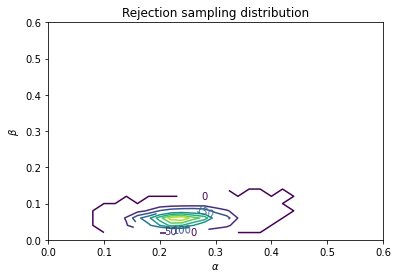

In [379]:
bins = 100
cts, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=bins, range=[[xmin, xmax], [ymin, ymax]])
xcenters = (xedges[:1] + xedges[1:]) / 2
ycenters = (yedges[:1] + yedges[1:]) / 2
CS = plt.contour(xcenters,ycenters, cts)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Rejection sampling distribution')
plt.ylim(0, 0.6)
plt.xlim(0, 0.6)
plt.show()

In [373]:
np.mean(samples, axis=0)

array([0.09582601, 0.46206395])

In [374]:
mean

[0.08080808080808081, 0.4444444444444445]

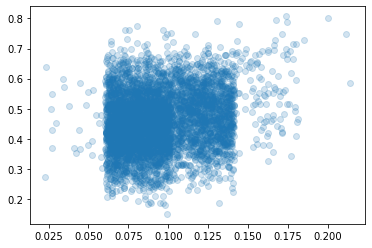

In [372]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.2)

In [306]:
sampling_scaling = k
sample = [-.1, .3]
disc_target_density(sample[0], sample[1])[0]
# sampling_scaling * multivariate_normal(sampling_mean, sampling_cov).pdf(sample)

0.0